In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler, FixedLengthSimpleSampler
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation
from typing import List
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset,BaseFlowDataset,DDQNActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import getValidInvalidStartingPointsForSubFlowStart, getActivityArrayFromFlow
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMClassifier
from flowprintOptimal.sekigo.modeling.loggers import Logger
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from typing import List
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from torch.nn.utils.rnn import pack_sequence, unpack_sequence

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMFeatureExtractor,LinearPredictor
import warnings
warnings.filterwarnings('ignore')

In [20]:
flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")

In [21]:
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)
FT_filtered_flows = list(filter(lambda x : x.class_type != "FT",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "FT",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

True

In [22]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .2,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .5,min_activity_for_start_point= 25,sample_wise_train_ratio= 1, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)

{'chat': 0.01995616323974533, 'control': 0.34973477226998356, 'streaming': 0.1999581677473332}
overlapping points = 0
{'FT': 0.49921752738654146}
overlapping points = 0


In [23]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())

streaming    3372
control      3141
chat         2600
Name: count, dtype: int64
chat         1300
control       886
streaming     713
Name: count, dtype: int64


In [24]:
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)

: 

In [7]:
pd.Series(map(lambda x : x.class_type,split_flows["test_flows"])).value_counts()

control      3283
streaming    2952
chat         1255
FT             84
Name: count, dtype: int64

In [8]:
train_dataset  = DDQNActivityDataset(split_flows["train_flows"],label_to_index= None)
test_dataset  = DDQNActivityDataset(split_flows["test_flows"],label_to_index= train_dataset.label_to_index)

In [9]:
rewarder = Rewarder(max_length= 30,l= .05,num_labels= len(train_dataset.label_to_index))

In [10]:
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length_in_seconds= 5, max_length_in_seconds= 30)

In [11]:
memory = memory_filler.processDataset()

In [12]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index) + 1)
feature_extractor = LSTMFeatureExtractor(lstm_hidden_size= 64,lstm_input_size= 6,feature_dim= 64)
predictor = LinearPredictor(feature_dim= 64,num_classes= 5)
logger = Logger(verbose= True)
logger.default_step_size = 100



In [13]:
ddq_model = EarlyClassificationtrainer(feature_extractor= feature_extractor, predictor= predictor,train_dataset = train_dataset,test_dataset= test_dataset,logger= logger,device=device,model_replacement_steps= 100)

In [14]:
ddq_model.train(memory_dataset= memory_dataset,epochs= 10,batch_size= 64,model_lag_in_steps= 100,lr= .0005)

 ---- 100 metric loss = 0.6124824205040932
 ---- 200 metric loss = 0.5393246841430664
 ---- 1 metric test_eval_f1 = 0.04710647746254025
 ---- 1 metric test_eval_time = 1.0
 ---- 300 metric loss = 0.48633272856473925
 ---- 400 metric loss = 0.3654947565495968
 ---- 2 metric test_eval_f1 = 0.2597554432361681
 ---- 2 metric test_eval_time = 1.0520200686559282
 ---- 500 metric loss = 0.30656718283891676
 ---- 600 metric loss = 0.28421570114791395
 ---- 3 metric test_eval_f1 = 0.6354480213108128
 ---- 3 metric test_eval_time = 1.4261948772115132
 ---- 700 metric loss = 0.2620799595117569
 ---- 800 metric loss = 0.2551250731945038
 ---- 4 metric test_eval_f1 = 0.3839589468981935
 ---- 4 metric test_eval_time = 12.59030895167679
 ---- 900 metric loss = 0.25784628704190254
 ---- 1000 metric loss = 0.2525875502824783
 ---- 5 metric test_eval_f1 = 0.6622849352422336
 ---- 5 metric test_eval_time = 1.5615262740955902
 ---- 1100 metric loss = 0.23624782755970955
 ---- 1200 metric loss = 0.23672532

KeyboardInterrupt: 

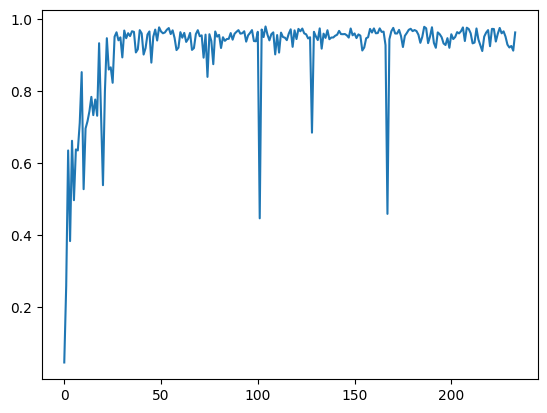

In [15]:
plt.plot(logger.getMetric("test_eval_f1"))

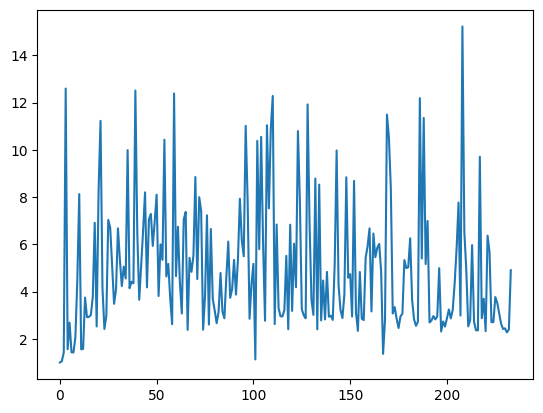

In [16]:
plt.plot(logger.getMetric("test_eval_time"))

In [ ]:
ddq_model.evalTrain()

1 metric train_eval_f1 = 0.9705990654197049
1 metric train_eval_time = 6.990379317652045


In [ ]:
ddq_model.evalTest()

71 metric test_eval_f1 = 0.9606025781616476
71 metric test_eval_time = 7.5106871577459815


In [ ]:
test_loader = DataLoader(dataset= test_dataset,batch_size= 64,shuffle= False)

In [ ]:
def getPrediction(preds,num_classes):
    for p in preds:
        if p < num_classes:
            return p
    return -1

def getPredictionTail(preds,num_classes):
    for p in reversed(preds):
        if p < num_classes:
            return p
    return -1

def predictionConsistency(pred : list,num_classes):
    is_predicted = None
    is_consistent = True
    for i,p in enumerate(pred):
        if p < num_classes:
            if is_predicted == None:
                is_predicted = (i+1,p)
            elif is_predicted[1] == p:
                continue
            else:
                is_consistent = False
                break
        
    return is_consistent


def strongPredictionConsistency(pred : list,num_classes):
    is_predicted = None
    is_consistent = True
    for i,p in enumerate(pred):
        if is_predicted == None:
            if p < num_classes:
                is_predicted = p
        else:
            if p != is_predicted:
                is_consistent = False
                break
        
    return is_consistent

def awarenessCheck(batch_preds : list,labels : list):
    is_aware = []
    for i in range(len(batch_preds)):
        if labels[i] in batch_preds[i]:
            is_aware.append(True)
        else:
            is_aware.append(False)

    return is_aware

In [ ]:
preds = []
tail_preds = []
labels = []
consistencies = []
awareness = []
original_preds = []

for batch in test_loader:
    batch_preds = ddq_model.predictStep(batch["flow"].float()).numpy().tolist()
    batch_labels = batch["label"].numpy().tolist()
    original_preds.extend(batch_preds)
    preds.extend(list(map(lambda x : getPrediction(x,len(test_dataset.label_to_index)),batch_preds)))
    tail_preds.extend(list(map(lambda x : getPredictionTail(x,len(test_dataset.label_to_index)),batch_preds)))
    labels.extend(batch_labels)
    awareness.extend(awarenessCheck(batch_preds= batch_preds,labels= batch_labels))

    consistencies.extend(list(map(lambda x : strongPredictionConsistency(x,len(test_dataset.label_to_index)),batch_preds)))

In [ ]:
preds = np.array(preds)
tail_preds = np.array(tail_preds)
labels = np.array(labels)
consistencies = np.array(consistencies)
awareness = np.array(awareness)

In [ ]:
awareness.sum()/awareness.shape

array([0.98450057])

In [ ]:
(preds == labels).sum()/preds.shape

array([0.9750287])

In [ ]:
consistencies.sum()/consistencies.shape

array([0.8315155])

In [ ]:
((~consistencies) & (preds == labels)).sum()/(~consistencies).sum()

0.9080068143100511

In [ ]:
((preds != labels) & (tail_preds == labels) & (~consistencies)).sum()/(preds != labels).sum()

0.367816091954023

In [ ]:
for pred,label in zip(preds,labels):
    predictionConsistency(pred,label,num_classes= len(test_dataset.label_to_index))

NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
incirrect (6, 0) 2
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
incirrect (9, 0) 1
NOT PREDICTED 3
(14, 0) (30, 1) 3
incirrect (14, 0) 3
NOT PREDICTED 3
NOT PREDICTED 3
(11, 1) (30, 0) 1
NOT PREDICTED 3
(8, 0) (23, 1) 1
incirrect (8, 0) 1
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 1
NOT PREDICTED 3
